In [52]:

import chardet
import pandas as pd

# Replace 'your_file.csv' with the path to your file
file_path = 'c:\\Users\\DELL\\OneDrive\\Documents\\memoire1\\export.csv'

# Detect file encoding
with open(file_path, 'rb') as f:
    result = chardet.detect(f.read())

encoding = result['encoding']
print(f"Detected encoding: {encoding}")

# Read the file with the detected encoding
df = pd.read_csv(file_path, encoding=encoding)


KeyboardInterrupt: 

# **Data Cleaning** 

In [45]:
from pyspark.sql.functions import col, sum
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Preprocessing") \
    .getOrCreate()

df = spark.read.csv("export.csv", header=True, inferSchema=True)
#Show the first few rows of the DataFrame
df.show(20)

# Print the schema of the DataFrame
df.printSchema()

# Count the number of records
print("Number of records:", df.count())

num_columns = len(df.columns)
print("Number of columns:", num_columns)

# Describe the DataFrame to get summary statistics
df.describe().show()
#columns manquate: no-ASSURE , RANg QTE_REJET1 

+--------------+----------------+------------+-------+--------+------------+------+------------+----+----+--------+------+-------------+----------+---------+----+-----------------+----+-----+---------+-----------+--------+
|NO_DOSSIER_NAT|N_ORDONNANCE_NAT|NO_LIGNE_NAT|NUM_ENR|PRIX_PPA|QUANTITE_MED| TARIF|APPLIC_TARIF|TAUX|  TS|NAT_REMB|CENTRE|DATE_PAIEMENT|    CODEPS| MT_MEDIC|ACTE|TRANCHE_AGE_BENEF|SEXE|REPCM|QTE_REJET|MOTIF_REJET|AFECTION|
+--------------+----------------+------------+-------+--------+------------+------+------------+----+----+--------+------+-------------+----------+---------+----+-----------------+----+-----+---------+-----------+--------+
|      15049819|               1|           2|   1777| 1307.33|          11|   0.0|           N|   1|NULL|       0| 13003|    23-JAN-23|      NULL|11504.504|1801|            16-24|   M| NULL|     NULL|       NULL|    NULL|
|      15049819|               1|           2|   1777| 1302.82|           4|   0.0|           N|   1|NULL|  

In [46]:
df.count()

100000

In [47]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan, lit
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, lit, udf
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.types import BooleanType

# 1. Drop rows where 'CODEPS' is null
df = df.filter(col('CODEPS').isNotNull())


#3 make qte-rejet type an integer
df = df.withColumn('QTE_REJET', df['QTE_REJET'].cast('int'))
#3.replace empty values in 'QTE_REJET' with 0
df = df.withColumn('QTE_REJET', 
                       when(col('QTE_REJET').isNull(), lit('0'))
                       .otherwise(col('QTE_REJET')))
#4. replace empty values in 'motif_rejet' with 'unknown' is qte_rejet is not 0 nor -1 else 'Not-rejected'
#cast qte_rejet to integer


df = df.withColumn('motif_rejet', 
                   when((col('motif_rejet').isNull()) & (col('qte_rejet').isin([0])), 'Not-rejected')
                   .otherwise(when(col('motif_rejet').isNull(), 'unknown').otherwise(col('motif_rejet')))
                  )

# 3. Handle missing values in 'TS'
# 3. Calculate the most common 'TS' for each medicine ('NUM_ENR' is assumed to be the medicine identifier)
# Group by 'NUM_ENR' and 'TS', count occurrences
medicine_ts_counts = df.groupBy('NUM_ENR', 'TS').count()

# Find the most common 'TS' for each medicine
window_spec = Window.partitionBy('NUM_ENR').orderBy(col('count').desc())
medicine_ts_mode = medicine_ts_counts.withColumn('row_number', row_number().over(window_spec)).filter(col('row_number') == 1).drop('row_number')

# Rename columns for clarity
medicine_ts_mode = medicine_ts_mode.select(col('NUM_ENR'), col('TS').alias('mode_TS'))

# Join the mode_TS back to the original data to fill in missing TS values
df = df.join(medicine_ts_mode, on='NUM_ENR', how='left')

# Replace missing 'TS' values with the mode 'TS' for each medicine
df = df.withColumn('TS', when(col('TS').isNull(), col('mode_TS')).otherwise(col('TS')))

# Drop rows where 'TS' is still null after imputation
df = df.filter(col('TS').isNotNull())

# Drop the auxiliary 'mode_TS' column
df = df.drop('mode_TS')


# Drop duplicate rows if any
df = df.dropDuplicates()
## List columns to check for missing values and handle them accordingly
columns_to_check = ['PRIX_PPA', 'QUANTITE_MED', 'TARIF', 'MT_MEDIC', 'ACTE']

# Impute missing values with mean for numerical columns
for column in columns_to_check:
    mean_value = df.agg({column: 'mean'}).first()[0]
    df = df.withColumn(column, when(col(column).isNull(), mean_value).otherwise(col(column)))

# Check the cleaned data
df.show(20)


+-------+--------------+----------------+------------+--------+------------+------+------------+----+---+--------+------+-------------+----------+--------+------+-----------------+----+-----+---------+------------+--------------------+
|NUM_ENR|NO_DOSSIER_NAT|N_ORDONNANCE_NAT|NO_LIGNE_NAT|PRIX_PPA|QUANTITE_MED| TARIF|APPLIC_TARIF|TAUX| TS|NAT_REMB|CENTRE|DATE_PAIEMENT|    CODEPS|MT_MEDIC|  ACTE|TRANCHE_AGE_BENEF|SEXE|REPCM|QTE_REJET| motif_rejet|            AFECTION|
+-------+--------------+----------------+------------+--------+------------+------+------------+----+---+--------+------+-------------+----------+--------+------+-----------------+----+-----+---------+------------+--------------------+
|   5365|       6032619|               2|           1|   173.4|         6.0| 173.4|           O|   O|  N|       2| 10101|    26-JAN-23| 101004287|  1040.4|1801.0|             >=85|   M|    1|        0|Not-rejected|              C17A02|
|   5299|       1313220|               2|           1|  

In [49]:

distinct_count = df.select('AFECTION').distinct().count()
print("Distinct AFECTION count:", distinct_count)

Distinct AFECTION count: 1206


In [60]:
#count number of distinct values in 'CODEPS'
distinct_count = df.select('CODEPS').distinct().count() 
print("Distinct CODEPS count:", distinct_count)


Distinct CODEPS count: 306


In [61]:
#number of rows in the DataFrame
num_rows = df.count()
print("Number of rows:", num_rows)

Number of rows: 76910


In [53]:
df = df.withColumn('QTE_REJET', df['QTE_REJET'].cast('int'))

# **Data Transformation**

In [51]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, when, split, explode, collect_list, concat_ws


# Replace null values in AFECTION with '-1' before splitting and exploding
df = df.withColumn("AFECTION", when(col("AFECTION").isNull(), lit("-1")).otherwise(col("AFECTION")))

# Split the AFECTION column by commas
df_split = df.withColumn("AFECTION_SPLIT", split(col("AFECTION"), ","))

# Explode the AFECTION_SPLIT column to separate rows
df_exploded = df_split.withColumn("AFECTION_EXPLODED", explode(col("AFECTION_SPLIT")))

# Filter the rows where the exploded AFECTION values start with 'C17' or 'C80'
df_filtered = df_exploded.filter(
    (col("AFECTION_EXPLODED").startswith("C17")) | 
    (col("AFECTION_EXPLODED").startswith("C80")) |
    (col("AFECTION_EXPLODED") == "-1")
)

# Aggregate back the filtered values into a list for each original row
df = df_filtered.groupBy(
    "NUM_ENR", "NO_DOSSIER_NAT", "N_ORDONNANCE_NAT", "NO_LIGNE_NAT", "PRIX_PPA", 
    "QUANTITE_MED", "TARIF", "APPLIC_TARIF", "TAUX", "TS", "NAT_REMB", "CENTRE", 
    "DATE_PAIEMENT", "CODEPS", "MT_MEDIC", "ACTE", "TRANCHE_AGE_BENEF", "SEXE", 
    "REPCM", "QTE_REJET", "motif_rejet"
).agg(
    concat_ws(",", collect_list("AFECTION_EXPLODED")).alias("AFECTION")
)

# Generate new columns for one-hot encoding
df = df.withColumn("C17", when(col("AFECTION").contains("C17"), lit(1)).otherwise(lit(0)))
df = df.withColumn("C80", when(col("AFECTION").contains("C80"), lit(1)).otherwise(lit(0)))
df = df.withColumn("-1", when(col("AFECTION").contains("-1"), lit(1)).otherwise(lit(0)))
df = df.withColumn("C17_C80", when((col("AFECTION").contains("C17")) & (col("AFECTION").contains("C80")), lit(1)).otherwise(lit(0)))

# Generate new columns for one-hot encoding of SEXE
df = df.withColumn("SEXE_M", when(col("SEXE") == 'M', lit(1)).otherwise(lit(0)))
df = df.withColumn("SEXE_F", when(col("SEXE") == 'F', lit(1)).otherwise(lit(0)))

# Generate new columns for one-hot encoding of TS
df = df.withColumn("TS_O", when(col("TS") == 'O', lit(1)).otherwise(lit(0)))
df = df.withColumn("TS_N", when(col("TS") == 'N', lit(1)).otherwise(lit(0)))
# Show the final DataFrame with one-hot encoded columns
df.show(truncate=False)


+-------+--------------+----------------+------------+--------+------------+-----+------------+----+---+--------+------+-------------+----------+--------+------+-----------------+----+-----+---------+------------+--------+---+---+---+-------+------+------+----+----+
|NUM_ENR|NO_DOSSIER_NAT|N_ORDONNANCE_NAT|NO_LIGNE_NAT|PRIX_PPA|QUANTITE_MED|TARIF|APPLIC_TARIF|TAUX|TS |NAT_REMB|CENTRE|DATE_PAIEMENT|CODEPS    |MT_MEDIC|ACTE  |TRANCHE_AGE_BENEF|SEXE|REPCM|QTE_REJET|motif_rejet |AFECTION|C17|C80|-1 |C17_C80|SEXE_M|SEXE_F|TS_O|TS_N|
+-------+--------------+----------------+------------+--------+------------+-----+------------+----+---+--------+------+-------------+----------+--------+------+-----------------+----+-----+---------+------------+--------+---+---+---+-------+------+------+----+----+
|19     |4000920       |1               |1           |120.0   |1.0         |40.0 |O           |O   |N  |1       |12112 |05-JAN-23    |2101013878|32.0    |1801.0|35-44            |M   |NULL |0        

In [39]:

df.filter(col('c17') == 1).count()


27940

# **Data Exploration**

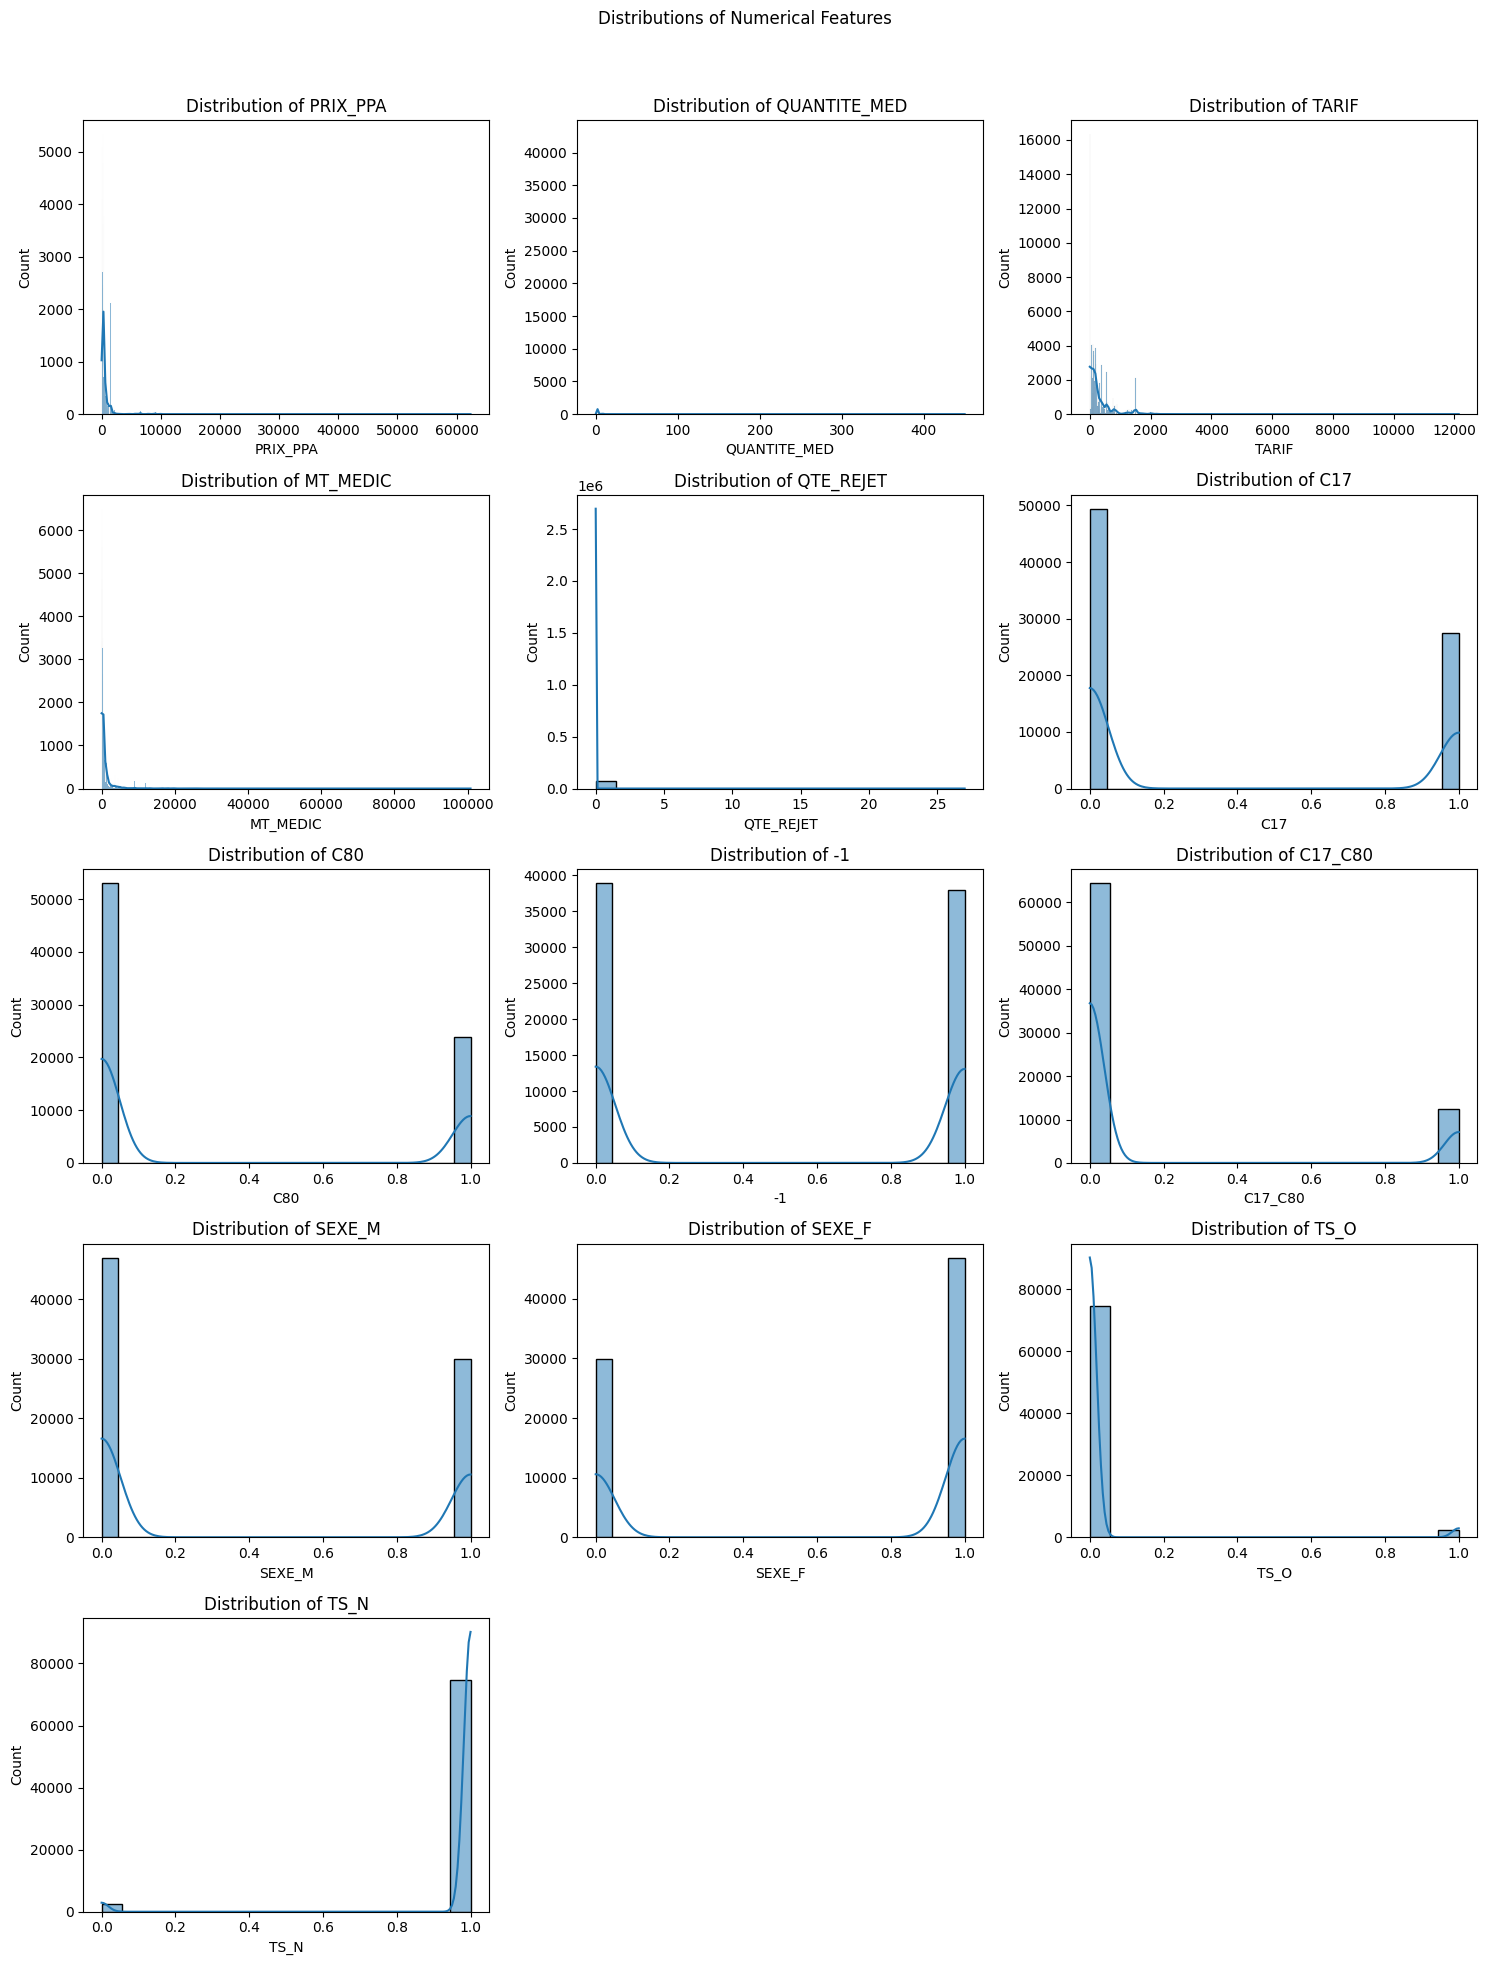

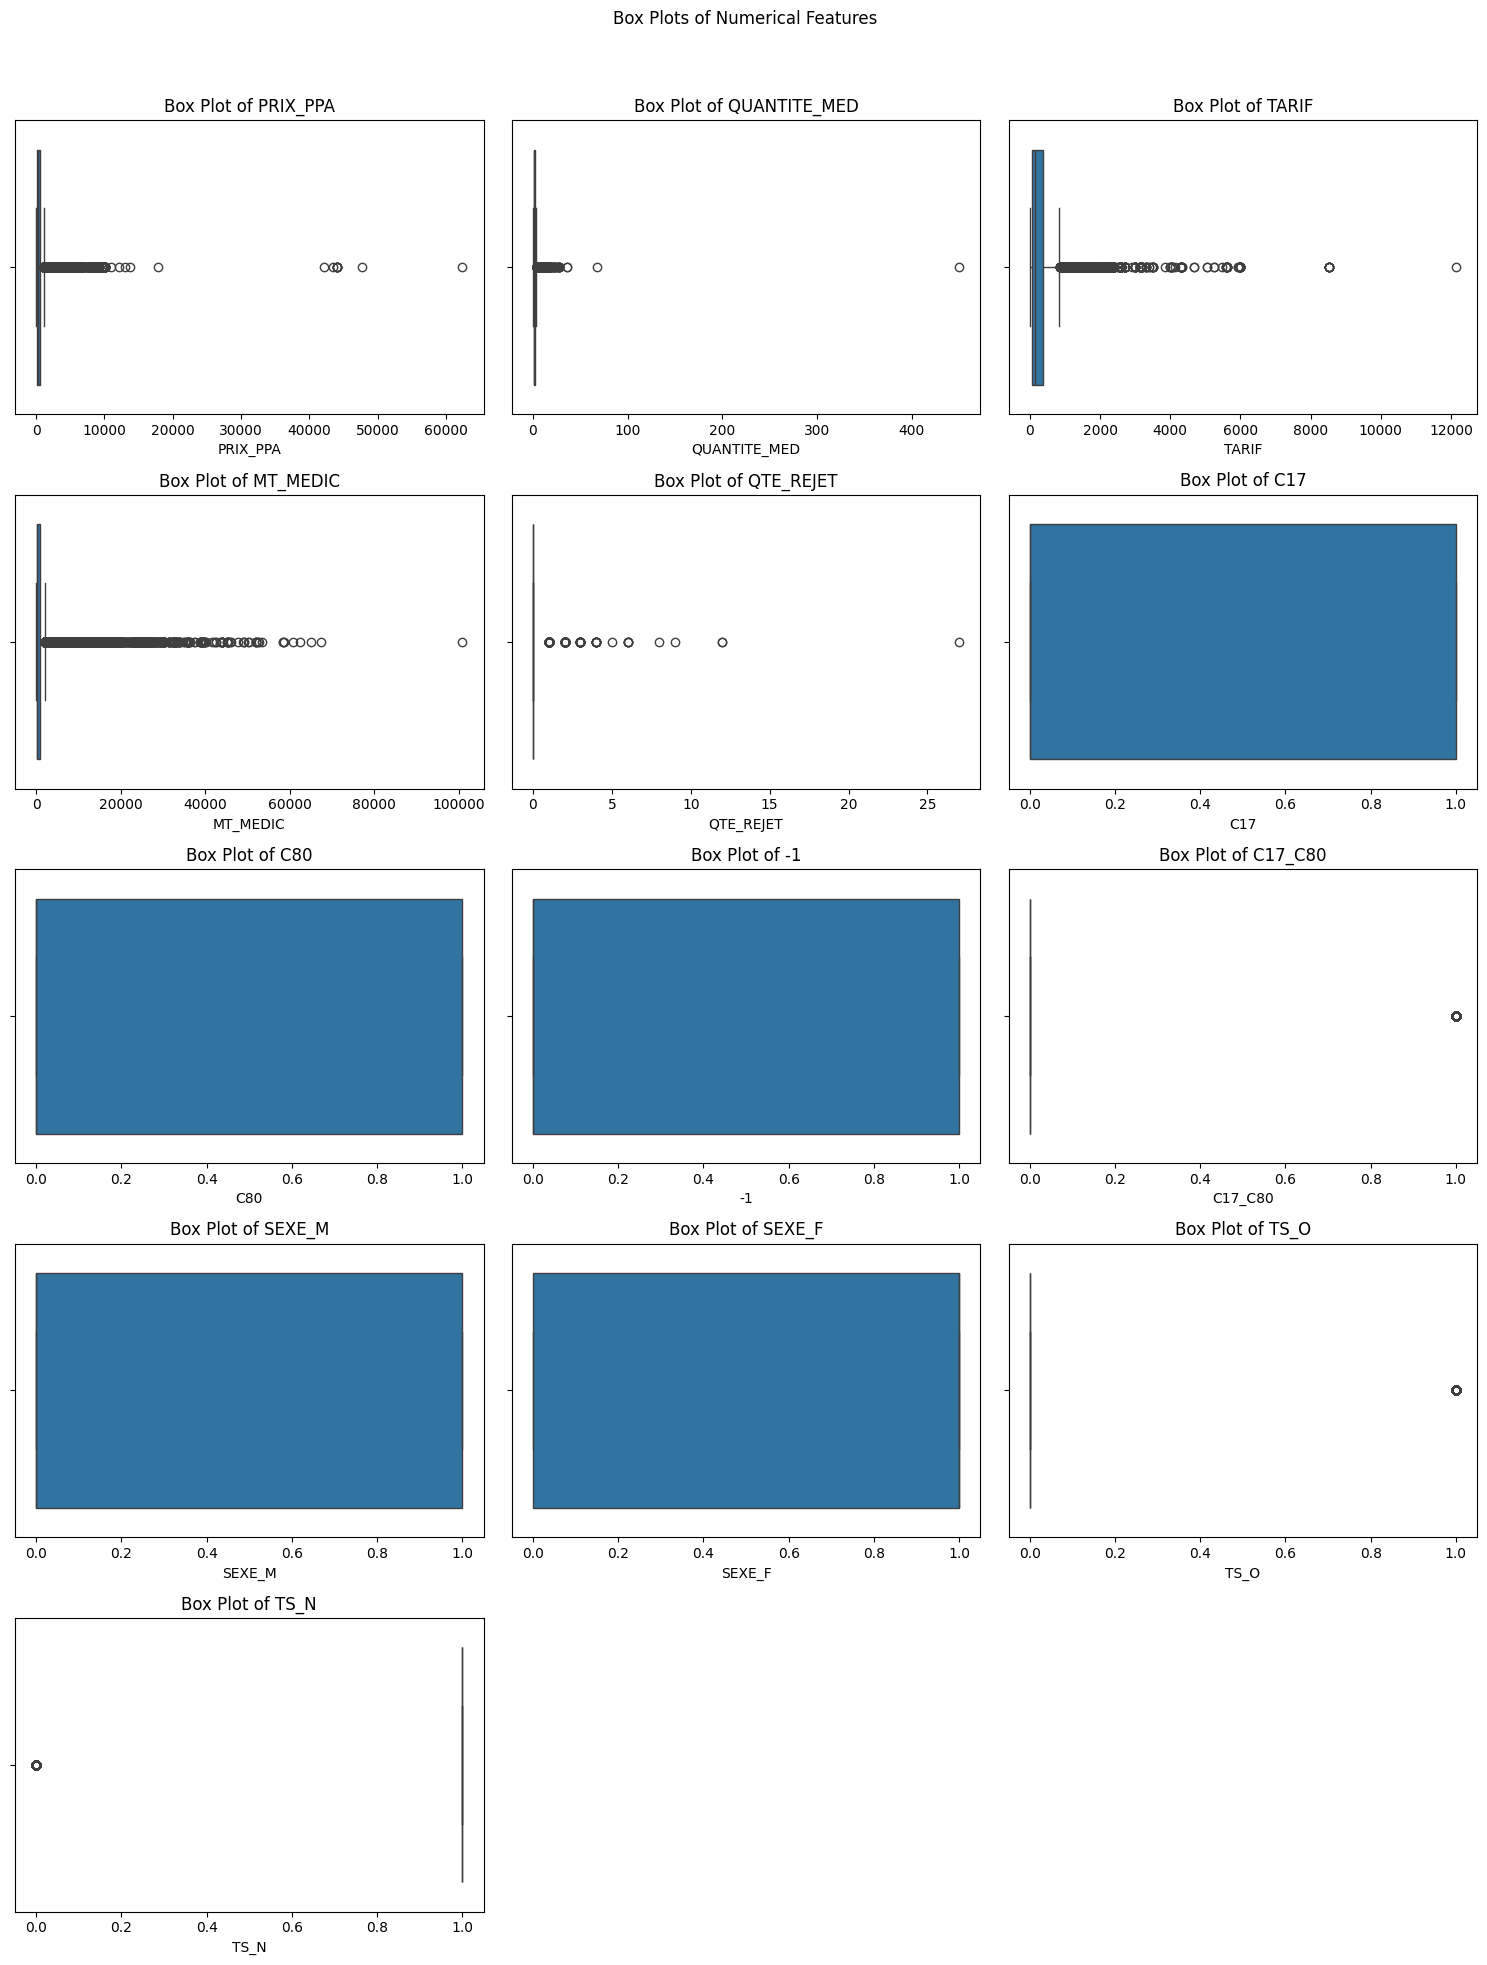

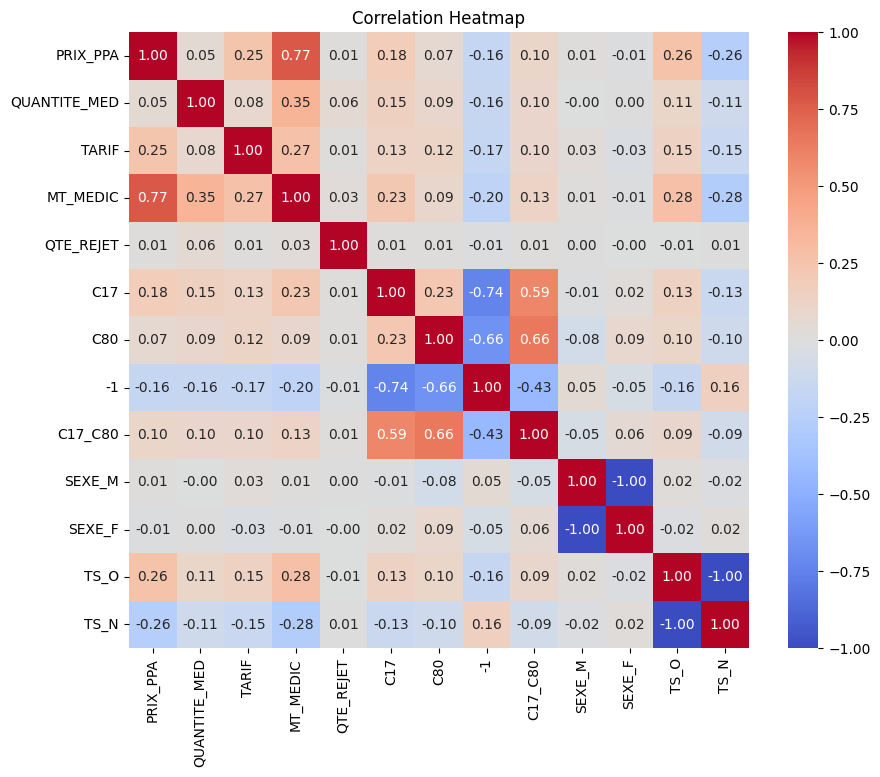

C:\Users\DELL\AppData\Local\Temp\ipykernel_22752\3826411574.py:67: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


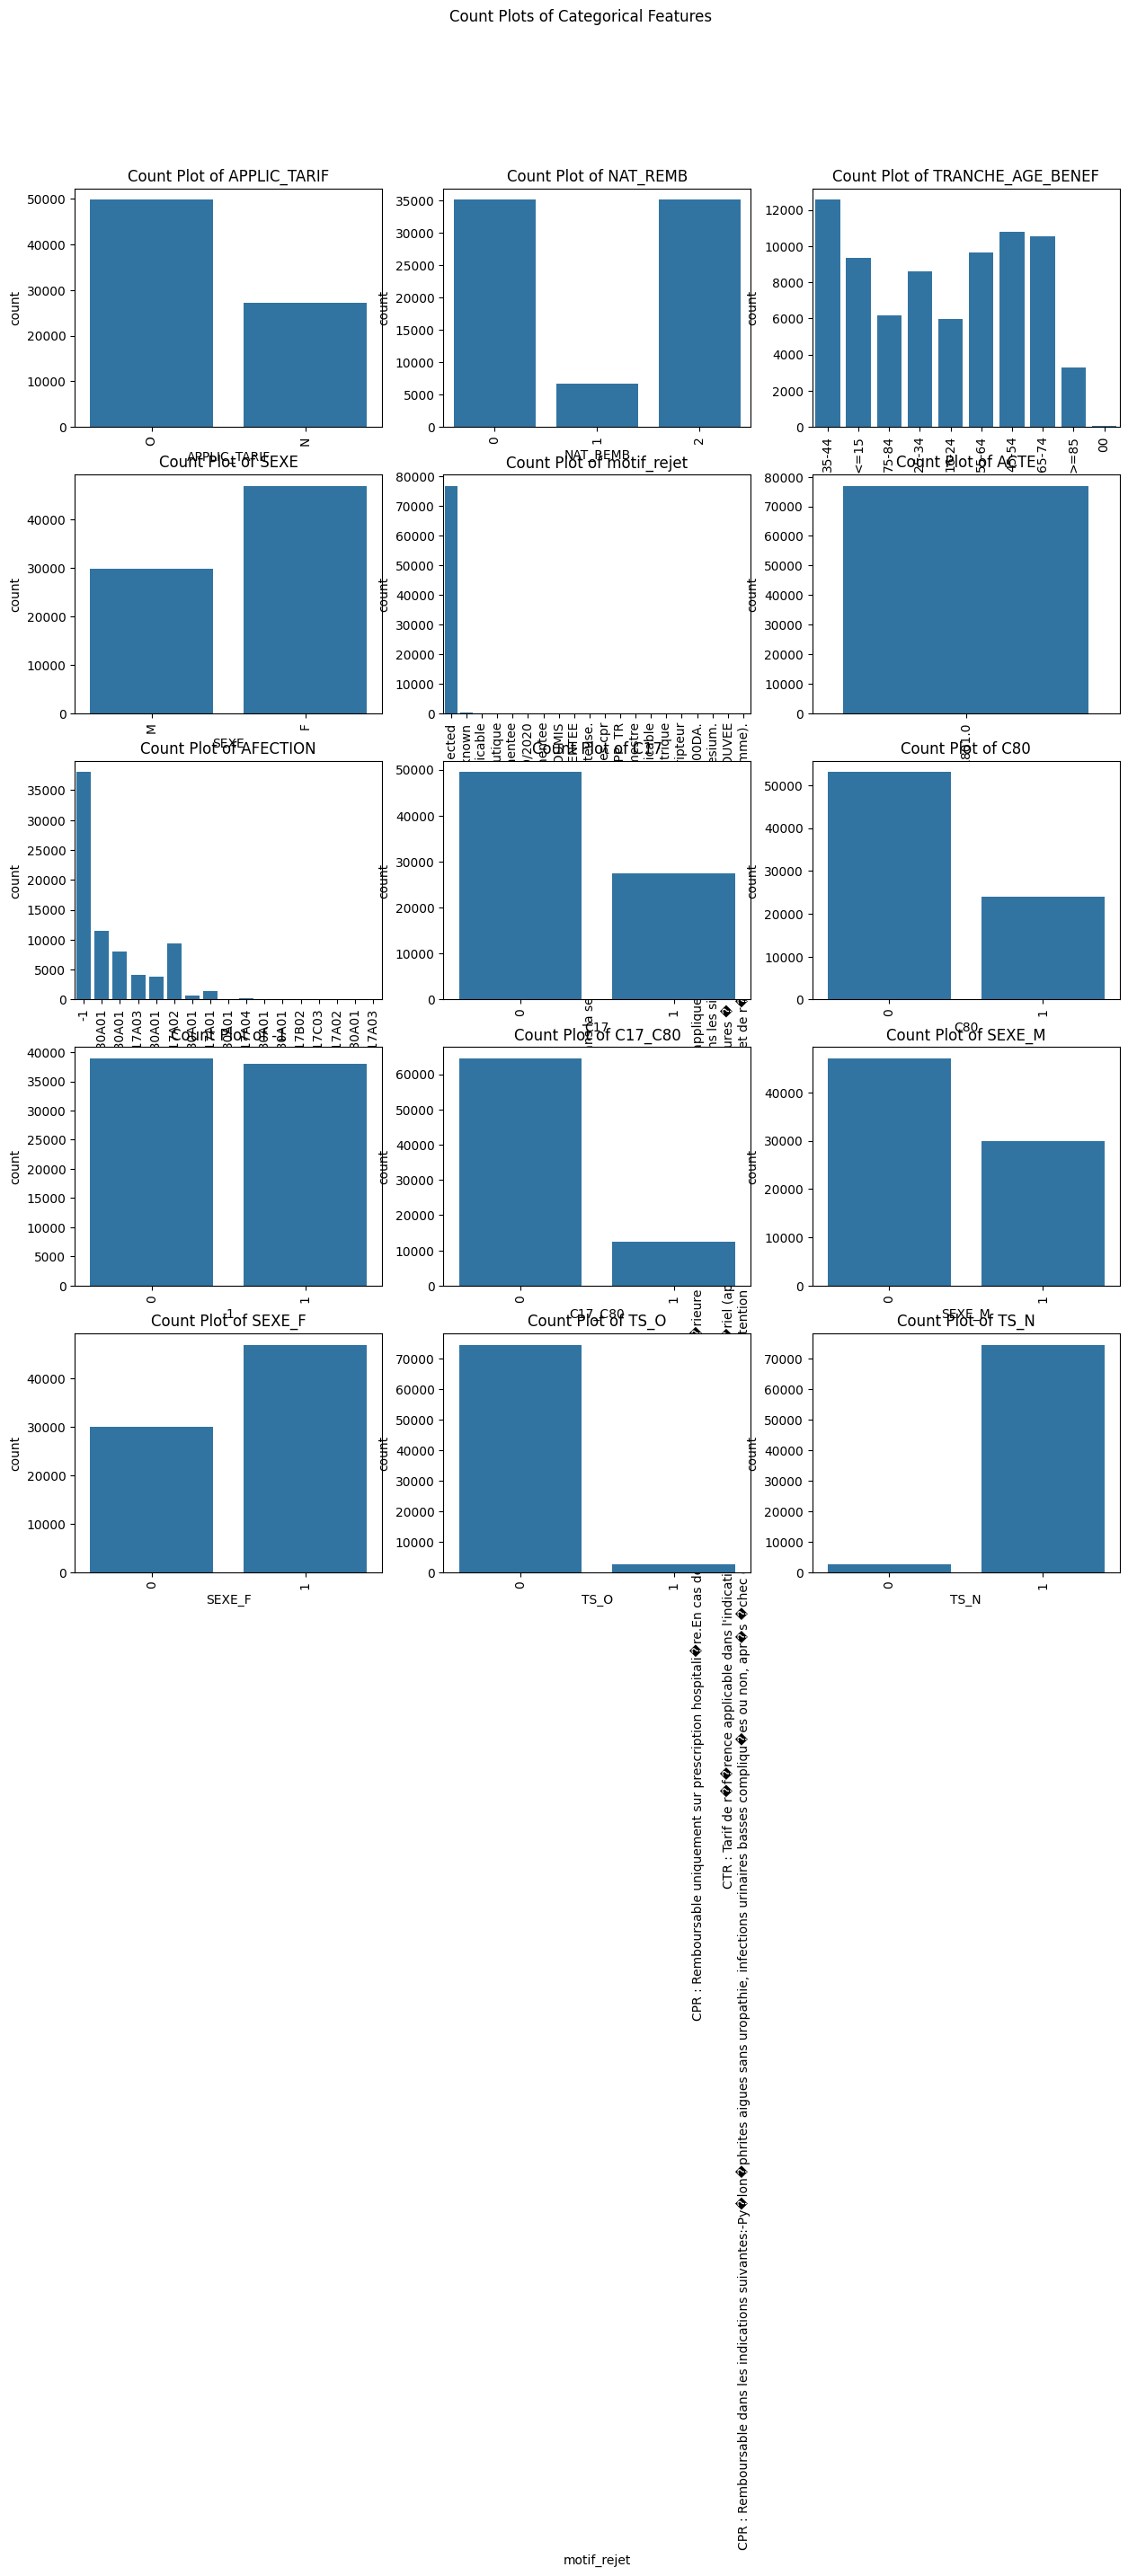

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


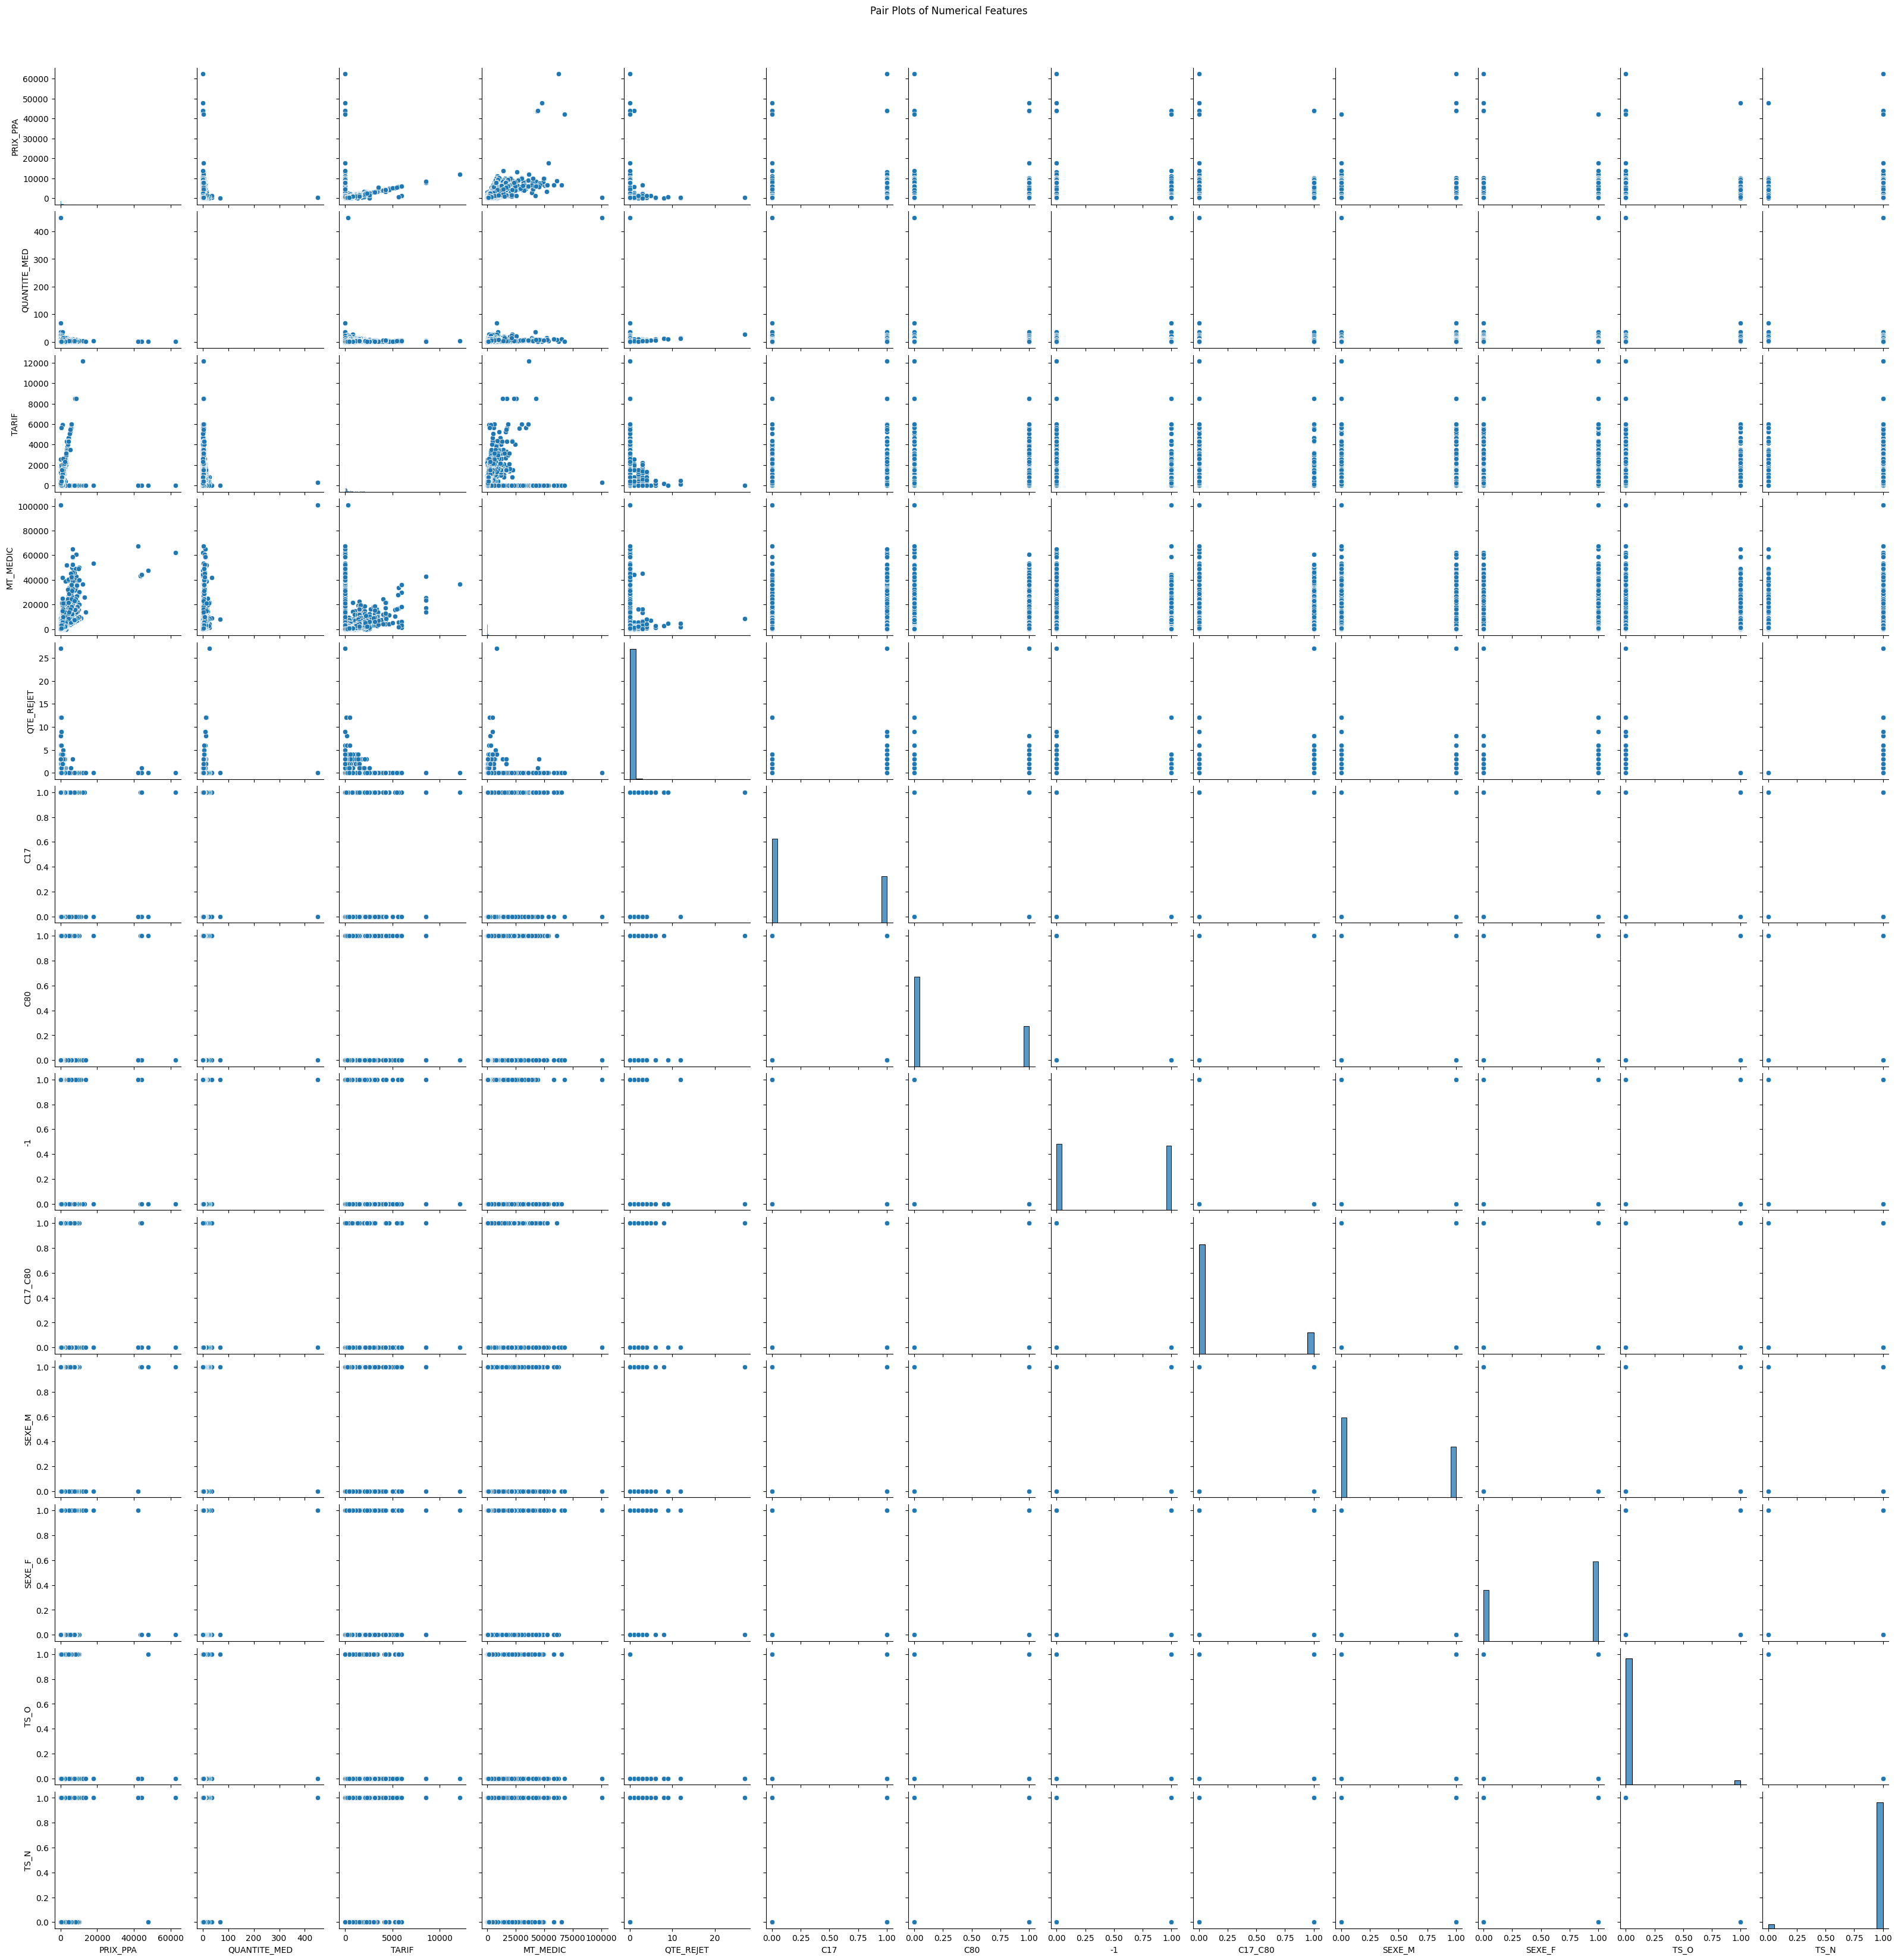

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Convert the Spark DataFrame to a Pandas DataFrame for visualization
data_pd = df.toPandas()

# Ensure all numerical columns are correctly typed
numerical_columns = ['PRIX_PPA', 'QUANTITE_MED', 'TARIF', 'MT_MEDIC', 'QTE_REJET', 'C17', 'C80', '-1', 'C17_C80', 'SEXE_M', 'SEXE_F', 'TS_O', 'TS_N']

# Convert columns to numeric, coerce errors to NaN
for column in numerical_columns:
    data_pd[column] = pd.to_numeric(data_pd[column], errors='coerce')

# Drop rows with NaN values in numerical columns
data_pd = data_pd.dropna(subset=numerical_columns)

# Function to plot distributions
def plot_distributions(df, columns, title):
    num_cols = 3
    num_rows = math.ceil(len(columns) / num_cols)
    plt.figure(figsize=(num_cols * 5, num_rows * 4))
    for i, column in enumerate(columns, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.histplot(df[column], kde=True)
        plt.title(f'Distribution of {column}')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_distributions(data_pd, numerical_columns, 'Distributions of Numerical Features')

# Function to plot boxplots
def plot_boxplots(df, columns, title):
    num_cols = 3
    num_rows = math.ceil(len(columns) / num_cols)
    plt.figure(figsize=(num_cols * 5, num_rows * 4))
    for i, column in enumerate(columns, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.boxplot(x=df[column])
        plt.title(f'Box Plot of {column}')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_boxplots(data_pd, numerical_columns, 'Box Plots of Numerical Features')

# Correlation Heatmap
corr_matrix = data_pd[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Count Plots for Categorical Features
categorical_columns = ['APPLIC_TARIF', 'NAT_REMB', 'TRANCHE_AGE_BENEF', 'SEXE', 'motif_rejet', 'ACTE', 'AFECTION', 'C17', 'C80', '-1', 'C17_C80', 'SEXE_M', 'SEXE_F', 'TS_O', 'TS_N']
num_cols = 3
num_rows = math.ceil(len(categorical_columns) / num_cols)
plt.figure(figsize=(num_cols * 5, num_rows * 4))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.countplot(data=data_pd, x=column)
    plt.title(f'Count Plot of {column}')
    plt.xticks(rotation=90)
plt.suptitle('Count Plots of Categorical Features')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Pair Plots
sns.pairplot(data_pd[numerical_columns])
plt.suptitle('Pair Plots of Numerical Features', y=1.02)
plt.show()


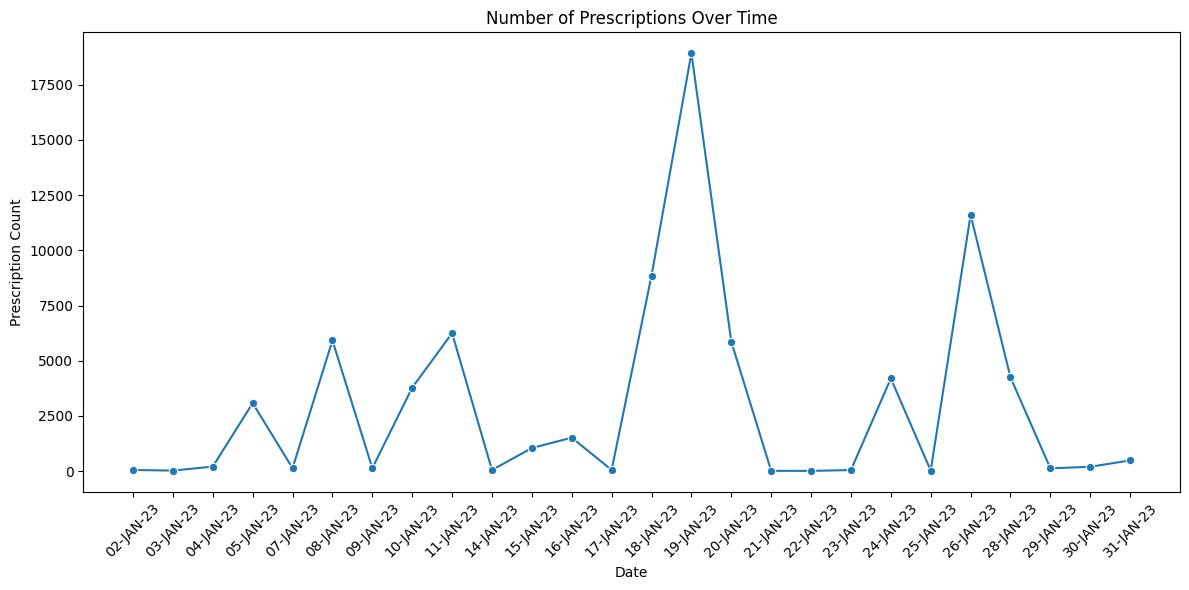

In [59]:
# Aggregate data by day
daily_data = data_pd.groupby('DATE_PAIEMENT').size().reset_index(name='Prescription_Count')

# Plot the time series data
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_data, x='DATE_PAIEMENT', y='Prescription_Count', marker='o')
plt.title('Number of Prescriptions Over Time')
plt.xlabel('Date')
plt.ylabel('Prescription Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


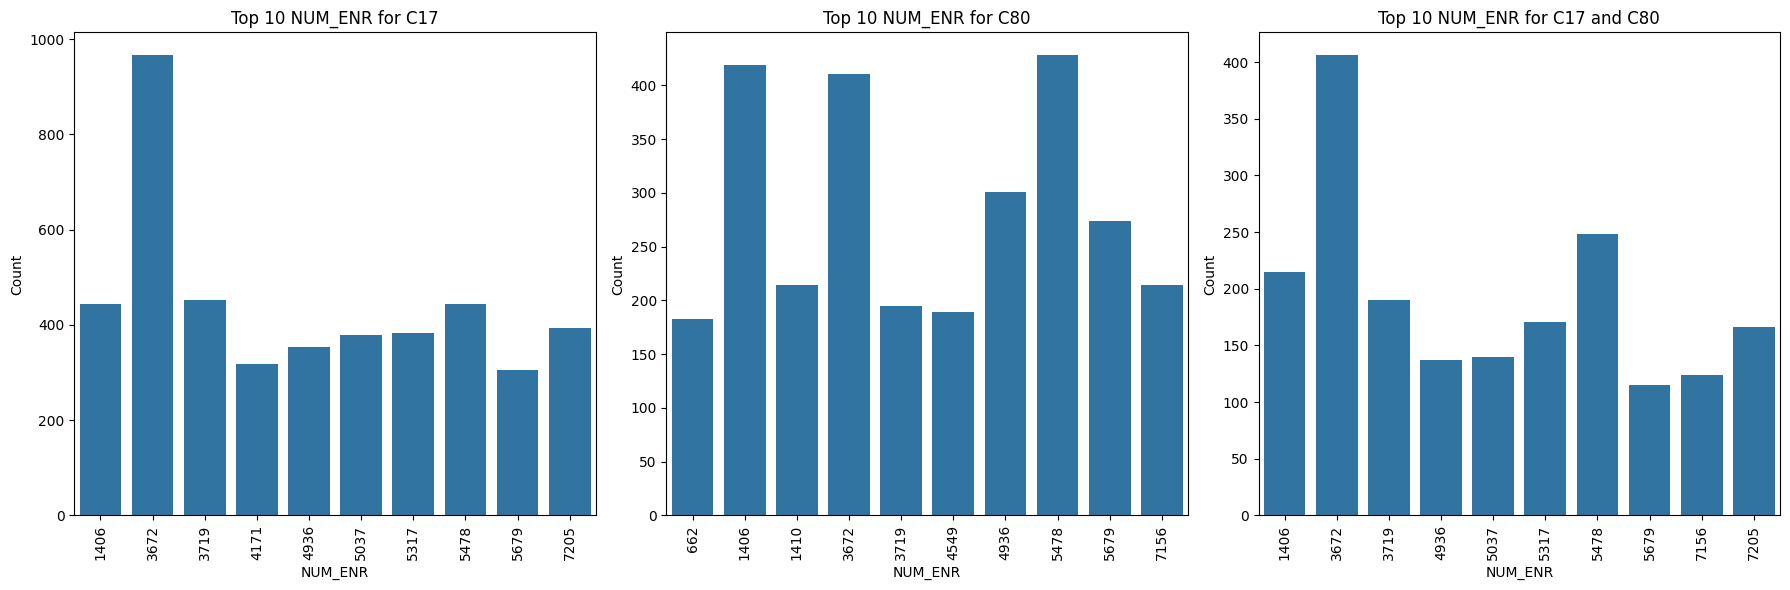

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spark DataFrame to a Pandas DataFrame for visualization
data_pd = df.toPandas()

# Ensure the necessary columns are in the correct format
data_pd['AFECTION'] = data_pd['AFECTION'].astype('category')

# Function to list top 10 NUM_ENR by AFECTION category
def top_10_num_enr_by_afection(df, afection_category):
    filtered_df = df[df['AFECTION'].str.contains(afection_category, na=False)]
    top_10 = filtered_df['NUM_ENR'].value_counts().head(10).reset_index()
    top_10.columns = ['NUM_ENR', 'Count']
    return top_10

# Get top 10 NUM_ENR for each AFECTION category
top_10_c17 = top_10_num_enr_by_afection(data_pd, 'C17')
top_10_c80 = top_10_num_enr_by_afection(data_pd, 'C80')
top_10_c17_c80 = top_10_num_enr_by_afection(data_pd, 'C17.*C80')  # Using regex to match both C17 and C80

# Plotting the data
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(data=top_10_c17, x='NUM_ENR', y='Count')
plt.title('Top 10 NUM_ENR for C17')
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.barplot(data=top_10_c80, x='NUM_ENR', y='Count')
plt.title('Top 10 NUM_ENR for C80')
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.barplot(data=top_10_c17_c80, x='NUM_ENR', y='Count')
plt.title('Top 10 NUM_ENR for C17 and C80')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_22752\332414122.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_pd['DATE_PAIEMENT'] = pd.to_datetime(data_pd['DATE_PAIEMENT'], errors='coerce')


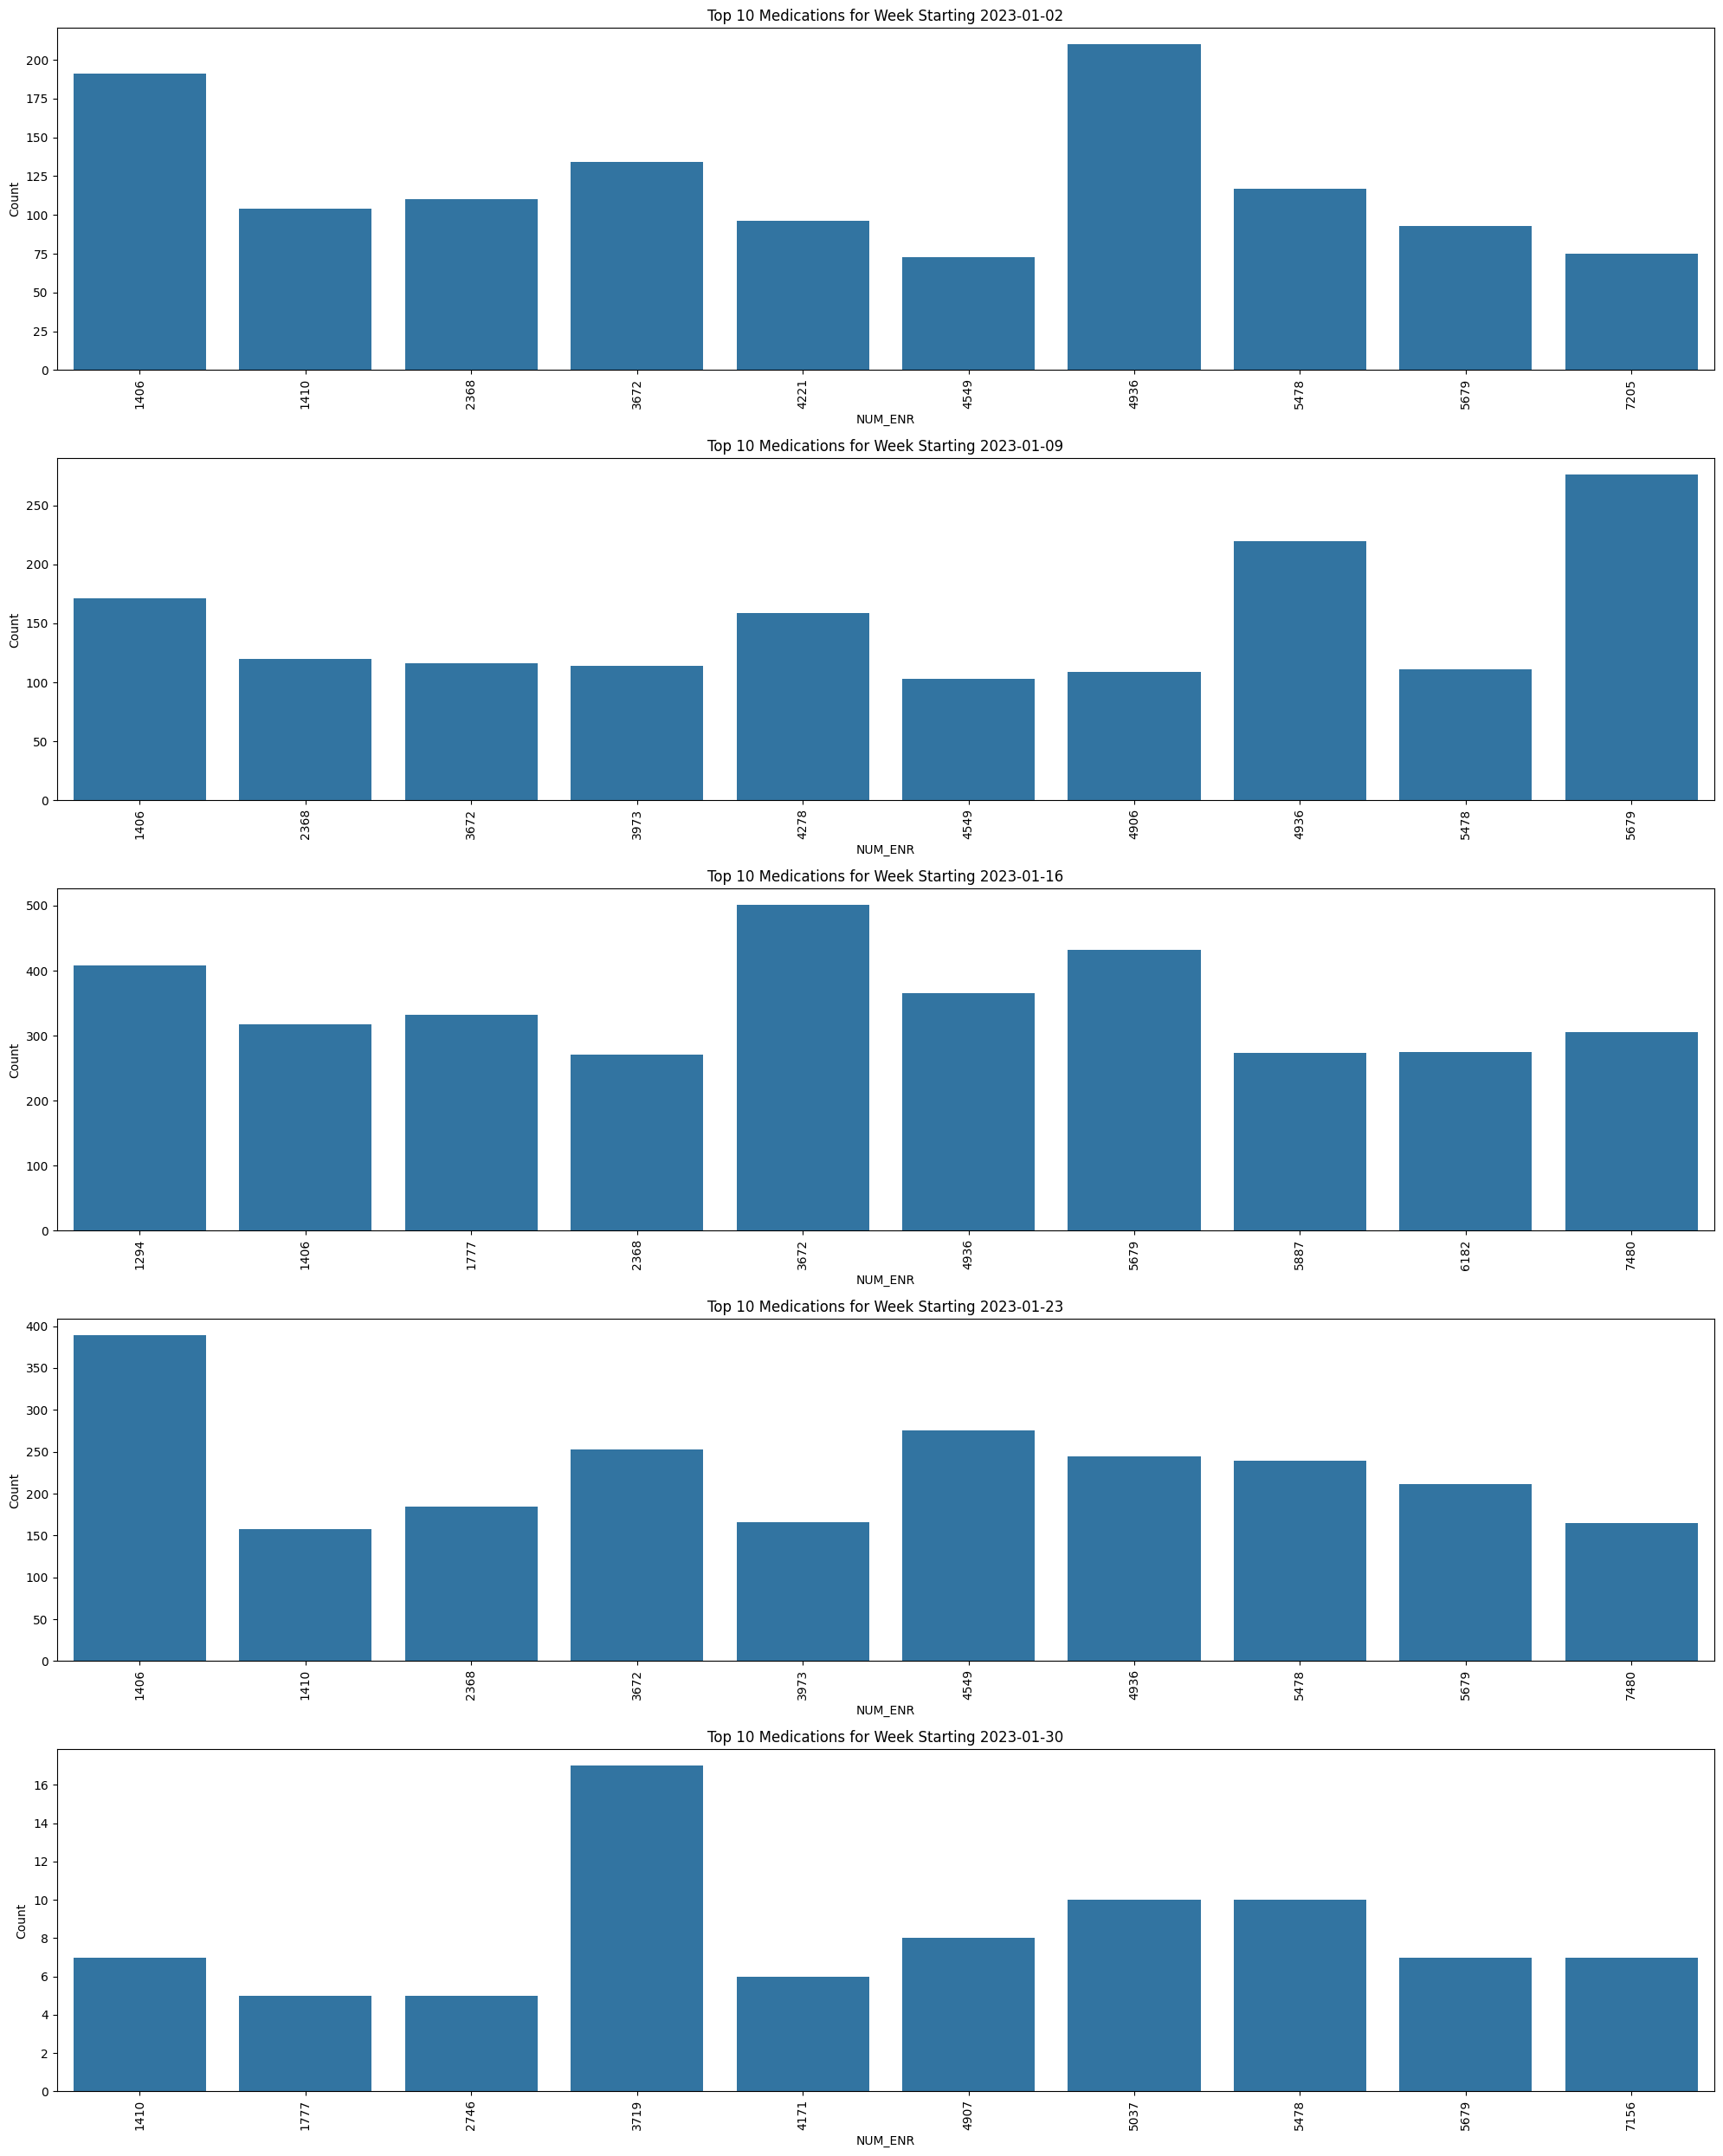

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spark DataFrame to a Pandas DataFrame for visualization
data_pd = df.toPandas()

# Ensure the DATE_PAIEMENT column is in datetime format
data_pd['DATE_PAIEMENT'] = pd.to_datetime(data_pd['DATE_PAIEMENT'], errors='coerce')

# Drop rows with NaN values in the DATE_PAIEMENT column
data_pd = data_pd.dropna(subset=['DATE_PAIEMENT'])

# Create a week-based column
data_pd['Week'] = data_pd['DATE_PAIEMENT'].dt.to_period('W').apply(lambda r: r.start_time)

# Function to get top 10 medications (NUM_ENR) per week
def top_10_medications_per_week(df):
    top_medications = df.groupby(['Week', 'NUM_ENR']).size().reset_index(name='Count')
    top_medications = top_medications.sort_values(['Week', 'Count'], ascending=[True, False])
    top_10_per_week = top_medications.groupby('Week').head(10)
    return top_10_per_week

# Get the top 10 medications per week
top_10_medications = top_10_medications_per_week(data_pd)

# Plotting the data
weeks = top_10_medications['Week'].unique()

plt.figure(figsize=(20, len(weeks) * 5))

for i, week in enumerate(weeks, 1):
    plt.subplot(len(weeks), 1, i)
    subset = top_10_medications[top_10_medications['Week'] == week]
    sns.barplot(data=subset, x='NUM_ENR', y='Count')
    plt.title(f'Top 10 Medications for Week Starting {week.strftime("%Y-%m-%d")}')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


# **Feature engineering**



In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2

# Assemble features
assembler = VectorAssembler(inputCols=["TOTAL_COST", "nombre_medicament"], outputCol="features")
transaction_features = assembler.transform(transactions_df)

# Split data into training and test sets
(train_data, test_data) = transaction_features.randomSplit([0.7, 0.3])
# Convert "IS_REJECTED" column to numeric type
train_data = train_data.withColumn("IS_REJECTED", col("IS_REJECTED").cast("double"))

# Train a logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="IS_REJECTED")
model = lr.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)
predictions.select("features", "IS_REJECTED", "prediction").show(5)

#accuracy on training data
train_predictions = model.transform(train_data)
train_accuracy = accuracy_score(train_predictions.select('IS_REJECTED').collect(), train_predictions.select('prediction').collect())
print(f"Training Accuracy: {train_accuracy}")

#accuracy on test data
test_accuracy = accuracy_score(predictions.select('IS_REJECTED').collect(), predictions.select('prediction').collect())
print(f"Test Accuracy: {test_accuracy}")


+--------------------+-----------+----------+
|            features|IS_REJECTED|prediction|
+--------------------+-----------+----------+
|        [234.22,5.0]|       true|       1.0|
|         [36.24,2.0]|       true|       1.0|
|[210.039999999999...|       true|       1.0|
|        [142.79,4.0]|      false|       1.0|
|        [118.78,4.0]|       true|       1.0|
+--------------------+-----------+----------+
only showing top 5 rows

Training Accuracy: 0.5092460881934566
Test Accuracy: 0.5


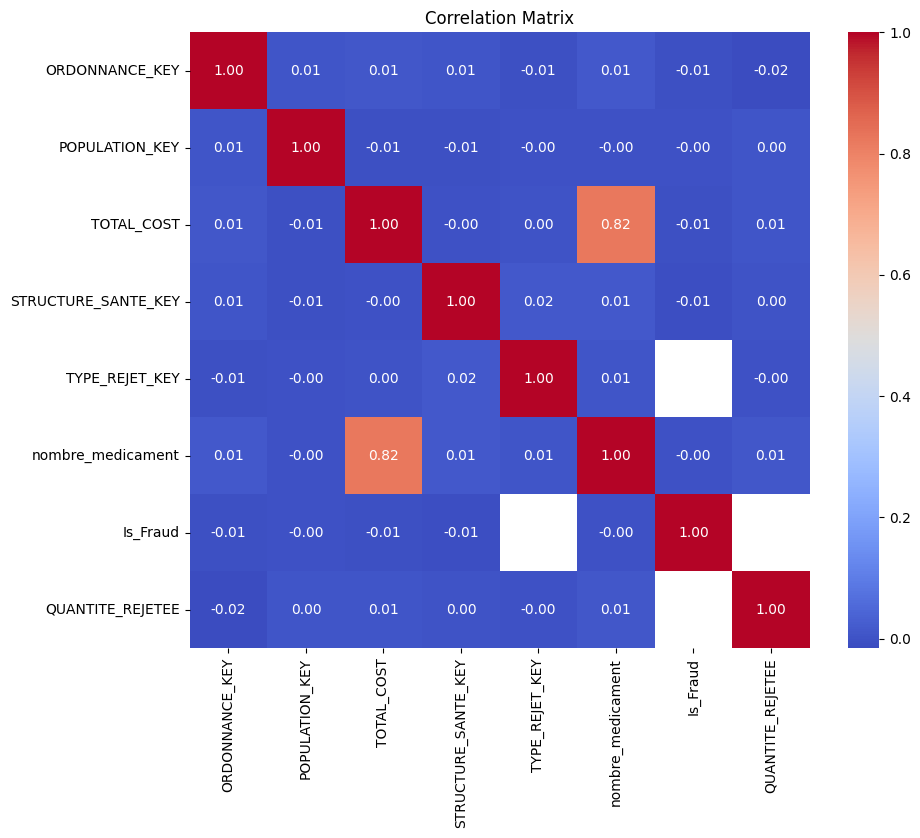

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql.types import StringType

# Convert 'DATE_PAYEMENT_KEY' column to string type
transactions_df = transactions_df.withColumn("DATE_PAYEMENT_KEY", col("DATE_PAYEMENT_KEY").cast(StringType()))

# Identify non-numeric columns
non_numeric_columns = [col for col, dtype in transactions_df.dtypes if dtype == 'string']

# Use StringIndexer and OneHotEncoder to encode non-numeric columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in non_numeric_columns]
encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], outputCols=[col+"_encoded" for col in non_numeric_columns])

# Create a Pipeline to execute indexers and encoder
pipeline = Pipeline(stages=indexers + [encoder])
encoded_df = pipeline.fit(transactions_df).transform(transactions_df)

# Define numeric_columns
numeric_columns = ["ORDONNANCE_KEY","POPULATION_KEY","TOTAL_COST","STRUCTURE_SANTE_KEY","TYPE_REJET_KEY","nombre_medicament","Is_Fraud","QUANTITE_REJETEE"]  # Add the actual numeric column names here

# Concatenate all encoded columns
encoded_columns = [col + "_encoded" for col in non_numeric_columns]
all_columns = numeric_columns + encoded_columns

# Select only numeric columns and those converted from boolean or date to numeric if needed
final_df = encoded_df.select(numeric_columns)  # Avoid including vector columns in correlation matrix

# Convert all selected columns to double, if not already
final_df = final_df.select([col(c).cast("double") for c in final_df.columns])

# Calculate correlation matrix
corr = final_df.toPandas().corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [ ]:
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
total_rejected_cost_pd = total_rejected_cost.toPandas()

# Write Pandas DataFrame to CSV file
total_rejected_cost_pd.to_csv("output/total_rejected_cost.csv", index=False)
predictions.toPandas().to_csv("output/predictions.csv", index=False)

